## Python Data fitting with various functions - HW 12
Due Monday Dec 1, 2025



Dowload the data "miniDR17.fits" from the TCU Online Week 14:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

_Use masking to remove any remaining bad values (typically 9999 or -9999 in this file_ , <b>but check!!!! If you are not sure, ask!!!</b>). 

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [3]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

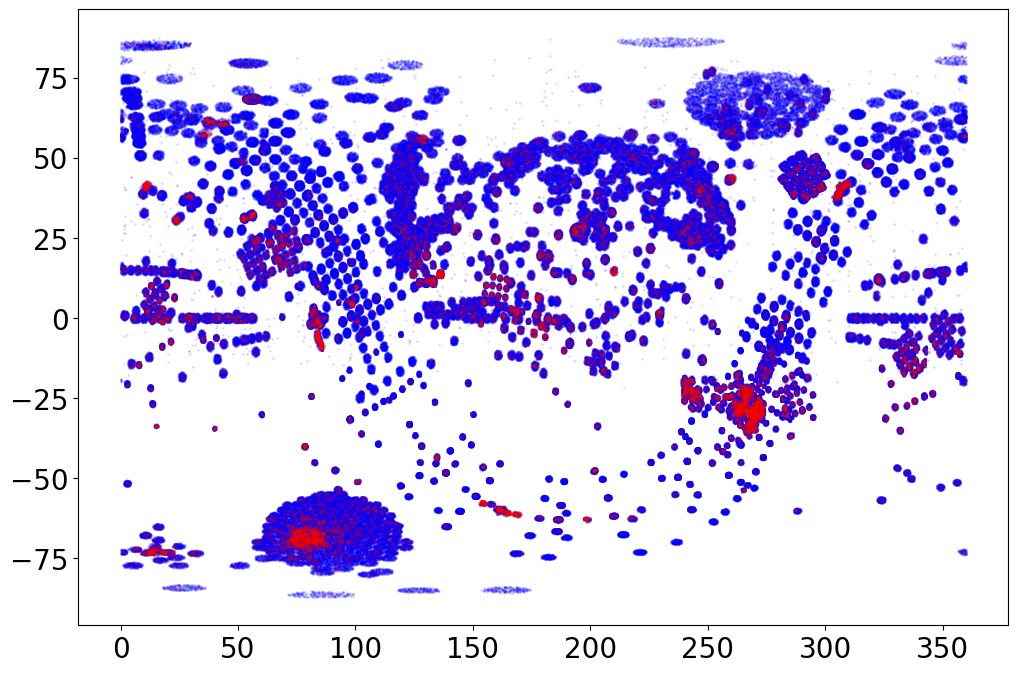

In [3]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)
ax.scatter(star['RA'][bad],star['DEC'][bad],s=1,c='r',alpha=0.1)


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.634
COSFIT: 72.947, 0.018, -0.452, -5.700


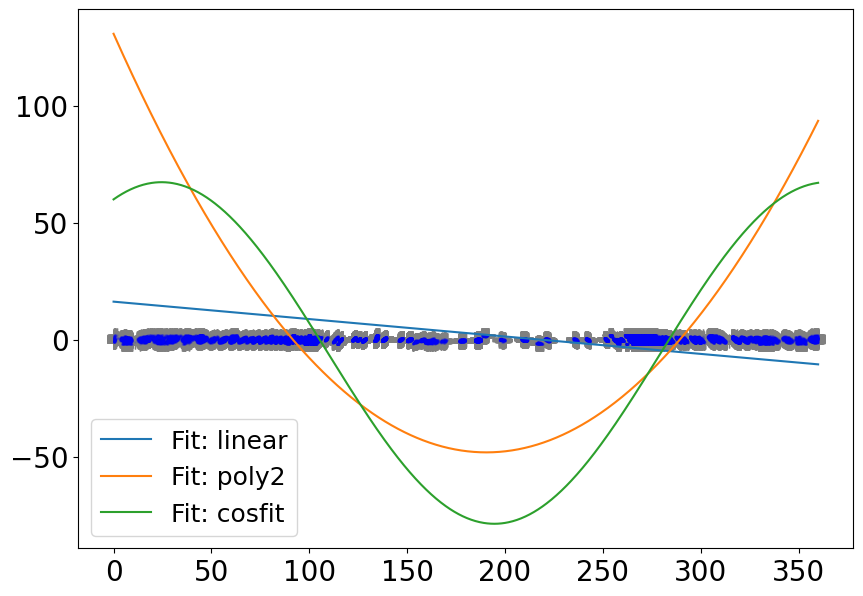

In [5]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 2) &\
     (star['GLAT'] > -2) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                          0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                         0.001,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                            0.001,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['RA'][cut1],star['GLAT'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['RA'][cut1]),star['GLAT'][cut1], xerr=(0.001),
             yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

# Homework #12

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_24_HW12a.ipynb

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: slope=-0.233, intercept=0.054
POLY2: A=-0.073, B=-0.317, C=0.048
POLY3: A=0.075, B=0.092, C=-0.262, D=0.045


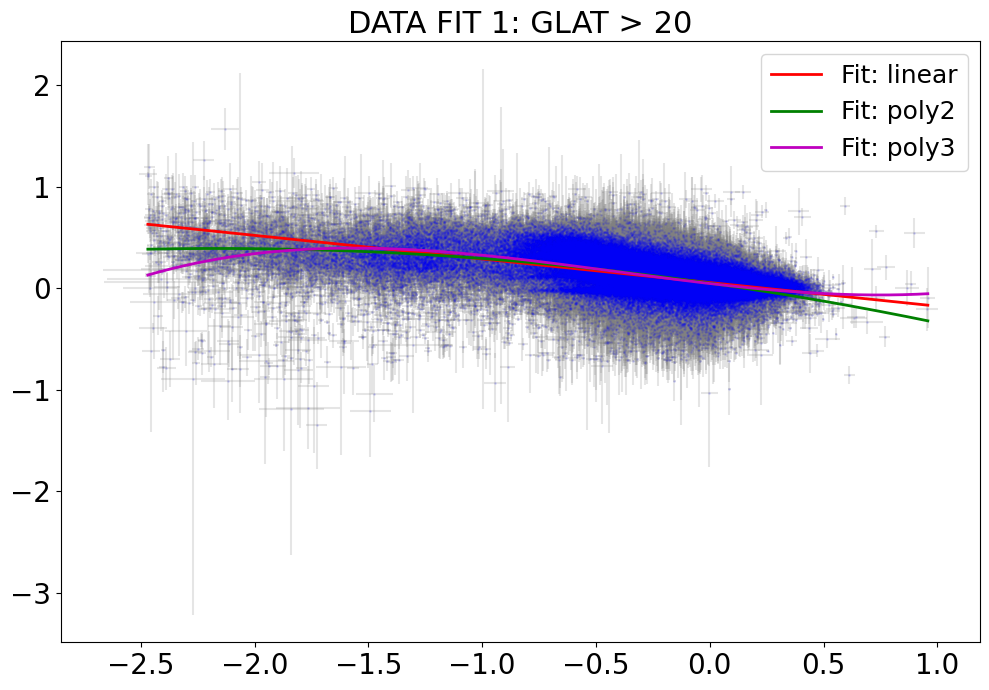

In [ ]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > 20) & \
     (star['FE_H'] != -9999) & (star['FE_H'] != 9999) & \
     (star['O_FE'] != -9999) & (star['O_FE'] != 9999) & \
     (np.isfinite(star['FE_H'])) & \
     (np.isfinite(star['O_FE'])) & \
     (np.isfinite(star['FE_H_ERR'])) & \
     (np.isfinite(star['O_FE_ERR']))
cut1 = np.where(ct1)[0]

Fe_H_ERR = star['FE_H_ERR'][cut1]
O_FE_ERR = star['O_FE_ERR'][cut1]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], Fe_H_ERR, \
                         O_FE_ERR, p0=[0,0])
print(f'LINEAR: slope={slope:.3f}, intercept={intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1], star['O_FE'][cut1], Fe_H_ERR, \
                         O_FE_ERR,p0=[1,1,1])
print(f'POLY2: A={polyA:.3f}, B={polyB:.3f}, C={polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
polyA3, polyB3, polyC3, polyD3 = mcFit4(poly3, star['FE_H'][cut1], star['O_FE'][cut1], Fe_H_ERR, \
                            O_FE_ERR,p0=[1,1,1,1])
print(f'POLY3: A={polyA3:.3f}, B={polyB3:.3f}, C={polyC3:.3f}, D={polyD3:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title('DATA FIT 1: GLAT > 20', fontsize=22)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1],
             xerr=Fe_H_ERR, yerr=O_FE_ERR,
             ecolor='grey',fmt='none', alpha=0.2, zorder=0)
             


#=================================================================================
# PLOT DATA FITS FROM ABOVE

x_plot = np.linspace(np.min(star['FE_H'][cut1]), 
                     np.max(star['FE_H'][cut1]), 1000) # X-PLOTING FOR FITS

#=================================================================================
ax1.plot(x_plot, linear(x_plot, slope, intercept), 'r-', linewidth=2, label='Fit: linear')
ax1.plot(x_plot, poly2(x_plot, polyA, polyB, polyC), 'g-', linewidth=2, label='Fit: poly2')
ax1.plot(x_plot, poly3(x_plot, polyA3, polyB3, polyC3, polyD3), 'm-', linewidth=2, label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.tight_layout()
plt.show()

# Linear is best fit.
#  No second population 



## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Number of stars selected: 38495
LINEAR: slope=-0.137, intercept=0.040
POLY2: A=-0.021, B=-0.146, C=0.041
POLY3: A=0.089, B=0.128, C=-0.131, D=0.033


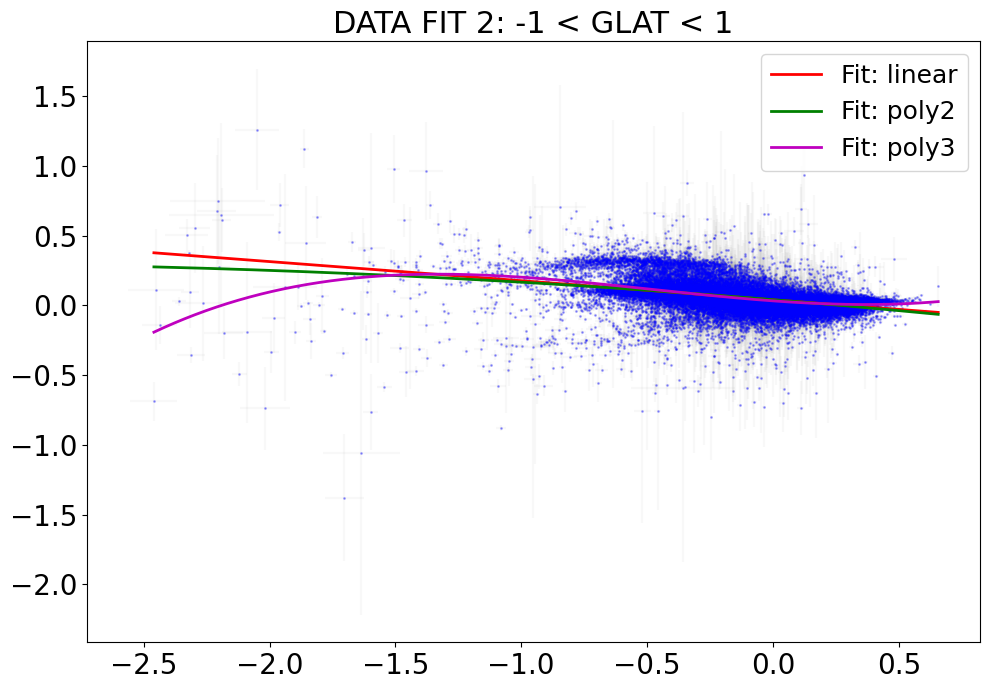

In [ ]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

ct2 = (np.bitwise_and(star['ASPCAPFLAG'], badbits) == 0) & \
(np.bitwise_and(star['STARFLAG'], suspectbits) == 0) & \
     (star['GLAT'] > -1) & ((star['GLAT'] < 1)) & \
     (star['FE_H'] != -9999) & (star['FE_H'] != 9999) & \
     (star['O_FE'] != -9999) & (star['O_FE'] != 9999) & \
     (np.isfinite(star['FE_H'])) & \
     (np.isfinite(star['O_FE'])) & \
     (np.isfinite(star['FE_H_ERR'])) & \
     (np.isfinite(star['O_FE_ERR']))

cut2 = np.where(ct2)[0]

Fe_H_ERR2 = star['FE_H_ERR'][cut2]
O_FE_ERR2 = star['O_FE_ERR'][cut2]

print(f"Number of stars selected: {len(cut2)}")

#=================================================================================
## LINEAR FIT (2 parameter)
slope2, intercept2 = mcFit2(linear, star['Fe_H'][cut2], star['O_FE'][cut2], Fe_H_ERR2, \
                         O_FE_ERR2, p0=[0,0])
print(f'LINEAR: slope={slope2:.3f}, intercept={intercept2:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA2, polyB2, polyC2,  = mcFit3(poly2, star['FE_H'][cut2], star['O_FE'][cut2], Fe_H_ERR2, \
                         O_FE_ERR2,p0=[1,1,1])
print(f'POLY2: A={polyA2:.3f}, B={polyB2:.3f}, C={polyC2:.3f}')

#=================================================================================
## POLY3 FIT (4 parameters)
polyA3_2, polyB3_2, polyC3_2, polyD3_2 = mcFit4(poly3, star['FE_H'][cut2], star['O_FE'][cut2], Fe_H_ERR2, \
                            O_FE_ERR2,p0=[1,1,1,1])
print(f'POLY3: A={polyA3_2:.3f}, B={polyB3_2:.3f}, C={polyC3_2:.3f}, D={polyD3_2:.3f}')
#=================================================================================

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot(111)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title('DATA FIT 2: -1 < GLAT < 1', fontsize=22)

# PLOT DATA AND ERROR BARS
ax2.scatter(star['FE_H'][cut2],star['O_FE'][cut2],s=1,c='b',alpha=0.3)
ax2.errorbar((star['FE_H'][cut2]),star['O_FE'][cut2],
             xerr=Fe_H_ERR2, yerr=O_FE_ERR2,
             ecolor='grey',fmt='none', alpha=0.2, zorder=0)
             
             
#=================================================================================
# PLOT DATA FITS FROM ABOVE

x_plot2 = np.linspace(np.min(star['FE_H'][cut2]), 
                     np.max(star['FE_H'][cut2]), 1000) # X-PLOTING FOR FITS

#=================================================================================
ax2.plot(x_plot2, linear(x_plot2, slope2, intercept2), 'r-', linewidth=2, label='Fit: linear')
ax2.plot(x_plot2, poly2(x_plot2, polyA2, polyB2, polyC2), 'g-', linewidth=2, label='Fit: poly2')
ax2.plot(x_plot2, poly3(x_plot2, polyA3_2, polyB3_2, polyC3_2, polyD3_2), 'm-', linewidth=2, label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.tight_layout()
plt.show()

# Linear is the best fit visually
# Scattered outliers, no consistent second population

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Number of stars selected: 39346
LINEAR: slope=0.000, intercept=0.355
POLY3: A=0.000, B=-0.000, C=0.002, D=-4.022


C:\Users\oprai\AppData\Local\Temp\ipykernel_41156\3954844722.py:20: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x + c) + d


EXPONENTIAL: A=-12.229, B=-0.348, C=-0.108, D=4.729


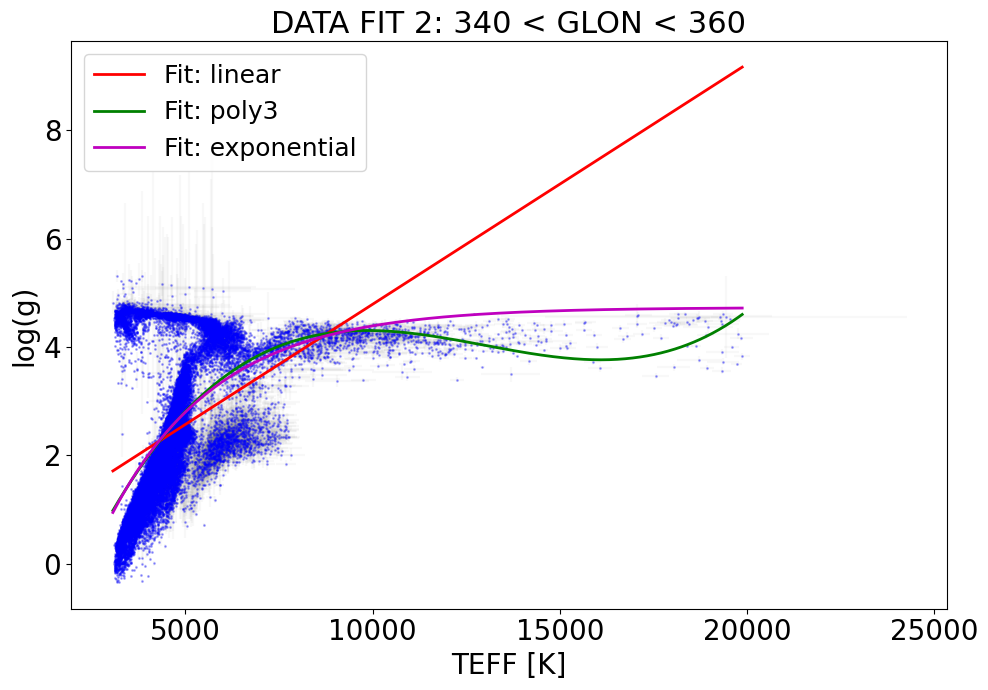

In [ ]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

ct3 = (np.bitwise_and(star['ASPCAPFLAG'], badbits) == 0) & \
(np.bitwise_and(star['STARFLAG'], suspectbits) == 0) & \
     (star['GLON'] > 340) & ((star['GLON'] < 360)) & \
     (star['TEFF'] != -9999) & (star['TEFF'] != 9999) & \
     (star['LOGG'] != -9999) & (star['LOGG'] != 9999) & \
     (np.isfinite(star['TEFF'])) & \
     (np.isfinite(star['LOGG'])) & \
     (np.isfinite(star['TEFF_ERR'])) & \
     (np.isfinite(star['LOGG_ERR']))

cut3 = np.where(ct3)[0]

TEFF_ERR3 = star['TEFF_ERR'][cut3]
LOGG_ERR3 = star['LOGG_ERR'][cut3]

print(f"Number of stars selected: {len(cut3)}")

teff_data = star['TEFF'][cut3]
teff_scaled = teff_data / 1000.0  # Scale to thousands of Kelvin
teff_err_scaled = TEFF_ERR3 / 1000.0

#=================================================================================
## LINEAR FIT (2 parameter)
slope3, intercept3 = mcFit2(linear, star['TEFF'][cut3], star['LOGG'][cut3], TEFF_ERR3, \
                         LOGG_ERR3, p0=[0,0])
print(f'LINEAR: slope={slope3:.3f}, intercept={intercept3:.3f}')

#=================================================================================
## POLY3 FIT (4 parameters)
polyA3, polyB3, polyC3, polyD3 = mcFit4(poly3, star['TEFF'][cut3], star['LOGG'][cut3], TEFF_ERR3, \
                            LOGG_ERR3,p0=[1,1,1,1])
print(f'POLY3: A={polyA3:.3f}, B={polyB3:.3f}, C={polyC3:.3f}, D={polyD3:.3f}')
#=================================================================================

## EXPONENTIAL FIT (4 parameter)
# Note: Exponential fits can be tricky - may need to adjust initial guesses
try:
    expA3, expB3, expC3, expD3 = mcFit4(exponential, teff_scaled, star['LOGG'][cut3], 
                                        teff_err_scaled, LOGG_ERR3, p0=[5, -1, 0, 2])
    print(f'EXPONENTIAL: A={expA3:.3f}, B={expB3:.3f}, C={expC3:.3f}, D={expD3:.3f}')
    exp_success = True
except Exception as e:
    print(f"EXPONENTIAL: Fit failed - {e}")
    expA3, expB3, expC3, expD3 = 5, -1, 0, 2
    exp_success = False

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig3 = plt.figure(figsize=(10,7))
ax3 = fig3.add_subplot(111)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
ax3.set_xlabel('TEFF [K]', fontsize=20)
ax3.set_ylabel('log(g)', fontsize=20)
ax3.set_title('DATA FIT 2: 340 < GLON < 360', fontsize=22)

# PLOT DATA AND ERROR BARS
ax3.scatter(star['TEFF'][cut3],star['LOGG'][cut3],s=1,c='b',alpha=0.3)
ax3.errorbar((star['TEFF'][cut3]),star['LOGG'][cut3],
             xerr=TEFF_ERR3, yerr=LOGG_ERR3,
             ecolor='grey',fmt='none', alpha=0.2, zorder=0)
             
             
#=================================================================================
# PLOT DATA FITS FROM ABOVE

x_plot3 = np.linspace(np.min(star['TEFF'][cut3]), 
                     np.max(star['TEFF'][cut3]), 1000) # X-PLOTING FOR FITS
x_plot3_scaled = x_plot3 / 1000.0  # Scale for exponential

#=================================================================================
ax3.plot(x_plot3, linear(x_plot3, slope3, intercept3), 'r-', linewidth=2, label='Fit: linear')
ax3.plot(x_plot3, poly3(x_plot3, polyA3, polyB3, polyC3, polyD3), 'g-', linewidth=2, label='Fit: poly3')
ax3.plot(x_plot3, exponential(x_plot3_scaled, expA3, expB3, expC3, expD3), 'm-', linewidth=2, label='Fit: exponential')

plt.legend(loc='best', fontsize=18)
plt.tight_layout()
plt.show()

# Poly 3 is the best fit
# Two groups of outliers would be hard to caputre them reasonably with a best fit line

## DATA FIT 4

Fit  a linear, a exponential, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) (JK_ERR)__<br>
<br>
<b>NOTE: you will have to create a (J-K) error:</b>  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Number of stars selected: 54221
LINEAR: slope=-0.000250, intercept=1.907
EXPONENTIAL: A=2.735, B=-0.468, C=0.765, D=-0.079
POLY2: A=0.0000000318, B=-0.000645, C=3.047


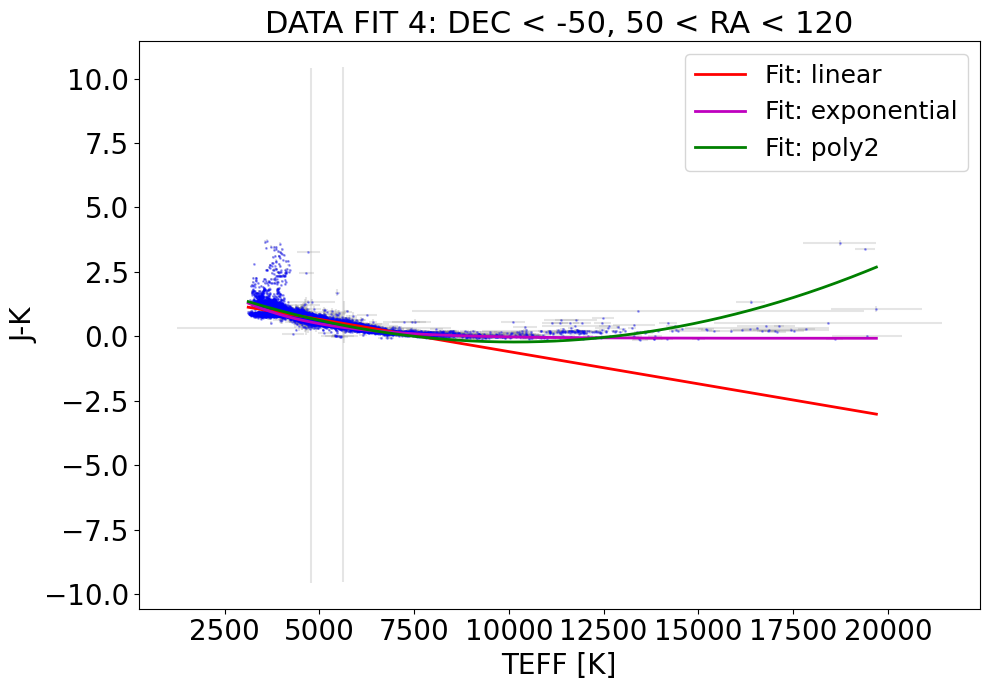

In [ ]:
# DATA FIT 4
# --------------------------------------------
# Select stars with DEC < -50 AND 50 < RA < 120
# Fit TEFF (TEFF_ERR) vs. (J-K)

badbits = 2**23        
suspectbits = 2**16    

#=================================================================================
# Make a Boolean Mask to remove bad data
ct4 = ((np.bitwise_and(star['ASPCAPFLAG'], badbits) == 0) & 
       (np.bitwise_and(star['STARFLAG'], suspectbits) == 0) & 
       (star['DEC'] < -50) & (star['RA'] > 50) & (star['RA'] < 120) &
       (star['TEFF'] != -9999) & (star['TEFF'] != 9999) & 
       (star['J'] != -9999) & (star['J'] != 9999) &
       (star['K'] != -9999) & (star['K'] != 9999) &
       (np.isfinite(star['TEFF'])) & 
       (np.isfinite(star['J'])) &
       (np.isfinite(star['K'])) &
       (np.isfinite(star['TEFF_ERR'])) & 
       (np.isfinite(star['J_ERR'])) &
       (np.isfinite(star['K_ERR'])))

cut4 = np.where(ct4)[0]

# Calculate J-K and its error
JK_color = star['J'][cut4] - star['K'][cut4]
JK_ERR = np.sqrt(star['J_ERR'][cut4]**2 + star['K_ERR'][cut4]**2)
TEFF_ERR4 = star['TEFF_ERR'][cut4]

print(f"Number of stars selected: {len(cut4)}")

#=================================================================================
## LINEAR FIT (2 parameter)
# X = TEFF, Y = J-K
slope4, intercept4 = mcFit2(linear, star['TEFF'][cut4], JK_color, 
                            TEFF_ERR4, JK_ERR, p0=[0,0])
print(f'LINEAR: slope={slope4:.6f}, intercept={intercept4:.3f}')

#=================================================================================
## EXPONENTIAL FIT (4 parameter)
# Scale TEFF for exponential
teff_data4 = star['TEFF'][cut4]
teff_scaled4 = teff_data4 / 1000.0
teff_err_scaled4 = TEFF_ERR4 / 1000.0

try:
    expA4, expB4, expC4, expD4 = mcFit4(exponential, teff_scaled4, JK_color, 
                                        teff_err_scaled4, JK_ERR, p0=[1, -0.5, 0, 0.5])
    print(f'EXPONENTIAL: A={expA4:.3f}, B={expB4:.3f}, C={expC4:.3f}, D={expD4:.3f}')
    exp_success = True
except Exception as e:
    print(f"EXPONENTIAL: Fit failed - {e}")
    expA4, expB4, expC4, expD4 = 1, -0.5, 0, 0.5
    exp_success = False

#=================================================================================
## POLY2 FIT (3 parameter)
polyA4, polyB4, polyC4 = mcFit3(poly2, star['TEFF'][cut4], JK_color, 
                                TEFF_ERR4, JK_ERR, p0=[1,1,1])
print(f'POLY2: A={polyA4:.10f}, B={polyB4:.6f}, C={polyC4:.3f}')

#=================================================================================
# PLOT THE DATA
fig4 = plt.figure(figsize=(10,7))
ax4 = fig4.add_subplot(111)
ax4.xaxis.set_tick_params(labelsize=20)
ax4.yaxis.set_tick_params(labelsize=20)
ax4.set_xlabel('TEFF [K]', fontsize=20)
ax4.set_ylabel('J-K', fontsize=20)
ax4.set_title('DATA FIT 4: DEC < -50, 50 < RA < 120', fontsize=22)

# PLOT DATA
ax4.scatter(star['TEFF'][cut4], JK_color, s=1, c='b', alpha=0.3)
ax4.errorbar((star['TEFF'][cut4]),(star['J'][cut4] - star['K'][cut4]),
             xerr=TEFF_ERR4, yerr=JK_ERR,
             ecolor='grey',fmt='none', alpha=0.2, zorder=0)

#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot4 = np.linspace(np.min(star['TEFF'][cut4]), 
                      np.max(star['TEFF'][cut4]), 1000)
x_plot4_scaled = x_plot4 / 1000.0

#=================================================================================
ax4.plot(x_plot4, linear(x_plot4, slope4, intercept4), 'r-', linewidth=2, label='Fit: linear')
ax4.plot(x_plot4, exponential(x_plot4_scaled, expA4, expB4, expC4, expD4), 'm-', linewidth=2, label='Fit: exponential')
ax4.plot(x_plot4, poly2(x_plot4, polyA4, polyB4, polyC4), 'g-', linewidth=2, label='Fit: poly2')

plt.legend(loc='best', fontsize=18)
plt.tight_layout()
plt.show()

# Exponential best fits the data
# Outliers in the upper left region. They could be captured with a sharp exponential decrease then leveled off for the rest

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON (0.0001) vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Number of stars selected: 196656
LINEAR: slope=-0.001, intercept=-3.966
POLY3: A=-0.000028, B=0.014, C=-1.781, D=27.971
COSFIT: A=49.827, B=0.022532, C=0.863, D=0.585


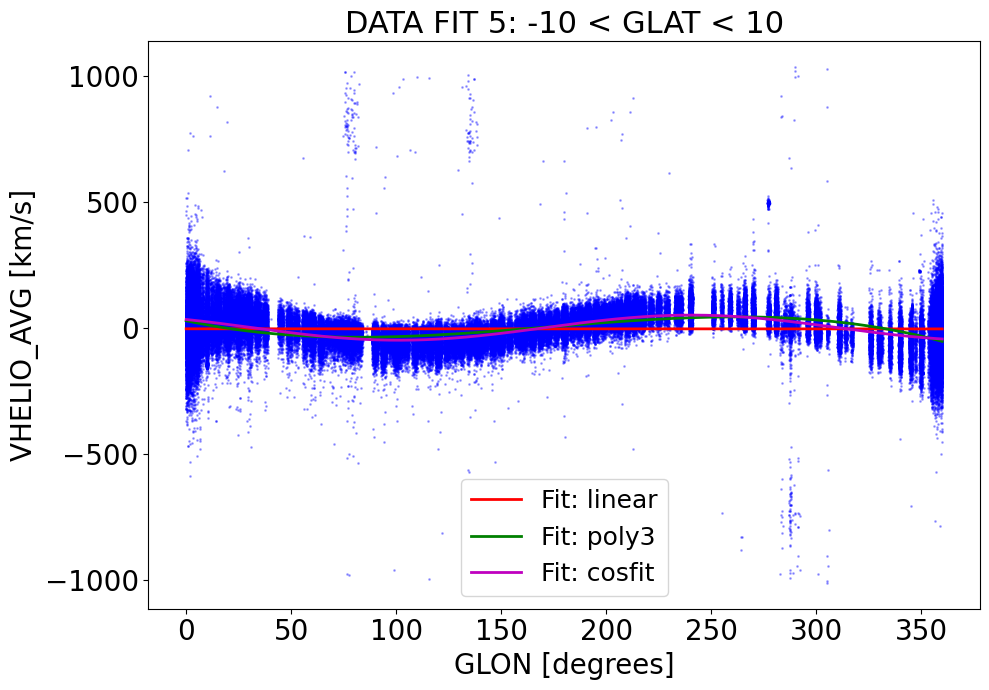

In [ ]:
# DATA FIT 5
# --------------------------------------------
# Select stars with -10 < GLAT < 10
# Fit GLON (0.0001) vs. VHELIO_AVG (VERR)

badbits = 2**23        
suspectbits = 2**16    

#=================================================================================
# Make a Boolean Mask to remove bad data
ct5 = ((np.bitwise_and(star['ASPCAPFLAG'], badbits) == 0) & 
       (np.bitwise_and(star['STARFLAG'], suspectbits) == 0) & 
       (star['GLAT'] > -10) & (star['GLAT'] < 10) &  # CHANGED: GLAT selection
       (star['GLON'] != -9999) & (star['GLON'] != 9999) &  # CHANGED: GLON
       (star['VHELIO_AVG'] != -9999) & (star['VHELIO_AVG'] != 9999) &  # CHANGED: VHELIO_AVG
       (np.isfinite(star['GLON'])) & 
       (np.isfinite(star['VHELIO_AVG'])) &
       (np.isfinite(star['VERR'])))  # CHANGED: VERR

cut5 = np.where(ct5)[0]

# Extract data and errors
GLON_ERR5 = 0.0001  # Fixed error value for GLON
VERR5 = star['VERR'][cut5]

print(f"Number of stars selected: {len(cut5)}")

#=================================================================================
## LINEAR FIT (2 parameter)
slope5, intercept5 = mcFit2(linear, star['GLON'][cut5], star['VHELIO_AVG'][cut5], 
                            GLON_ERR5, VERR5, p0=[0,0])
print(f'LINEAR: slope={slope5:.3f}, intercept={intercept5:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
polyA5, polyB5, polyC5, polyD5 = mcFit4(poly3, star['GLON'][cut5], star['VHELIO_AVG'][cut5], 
                                        GLON_ERR5, VERR5, p0=[1,1,1,1])
print(f'POLY3: A={polyA5:.6f}, B={polyB5:.3f}, C={polyC5:.3f}, D={polyD5:.3f}')

#=================================================================================
## COSFIT (4 parameter)
try:
    cfA5, cfB5, cfC5, cfD5 = mcFit4(cosfit, star['GLON'][cut5], star['VHELIO_AVG'][cut5], 
                                    GLON_ERR5, VERR5, p0=[100, 0.02, 0, 0])
    print(f'COSFIT: A={cfA5:.3f}, B={cfB5:.6f}, C={cfC5:.3f}, D={cfD5:.3f}')
    cos_success = True
except Exception as e:
    print(f"COSFIT: Fit failed - {e}")
    cfA5, cfB5, cfC5, cfD5 = 100, 0.02, 0, 0
    cos_success = False

#=================================================================================
# PLOT THE DATA
fig5 = plt.figure(figsize=(10,7))
ax5 = fig5.add_subplot(111)
ax5.xaxis.set_tick_params(labelsize=20)
ax5.yaxis.set_tick_params(labelsize=20)
ax5.set_xlabel('GLON [degrees]', fontsize=20)
ax5.set_ylabel('VHELIO_AVG [km/s]', fontsize=20)
ax5.set_title('DATA FIT 5: -10 < GLAT < 10', fontsize=22)

# PLOT DATA
ax5.scatter(star['GLON'][cut5], star['VHELIO_AVG'][cut5], s=1, c='b', alpha=0.3)
ax4.errorbar((star['TEFF'][cut4]),(star['VHELIO_AVG'][cut5]),
             xerr=TEFF_ERR3, yerr=LOGG_ERR3,
             ecolor='grey',fmt='none', alpha=0.2, zorder=0)

#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot5 = np.linspace(np.min(star['GLON'][cut5]), 
                      np.max(star['GLON'][cut5]), 1000)

#=================================================================================
ax5.plot(x_plot5, linear(x_plot5, slope5, intercept5), 'r-', linewidth=2, label='Fit: linear')
ax5.plot(x_plot5, poly3(x_plot5, polyA5, polyB5, polyC5, polyD5), 'g-', linewidth=2, label='Fit: poly3')
ax5.plot(x_plot5, cosfit(x_plot5, cfA5, cfB5, cfC5, cfD5), 'm-', linewidth=2, label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.tight_layout()
plt.show()

# Cosfit is best fit
# Scattered second population. Not consistent enough for a trend line

## DATA FIT 6

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Number of stars selected: 648123
LINEAR: slope=0.013, intercept=0.016
POLY2: A=0.024, B=0.038, C=0.017
POLY3: A=-0.021, B=-0.019, C=0.026, D=0.018


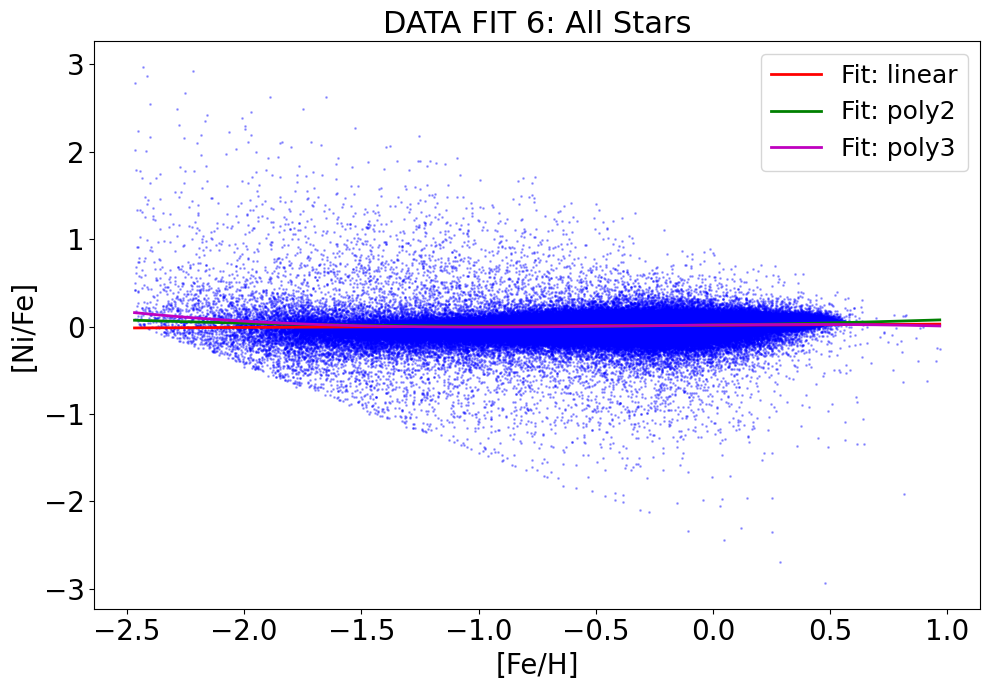

In [ ]:
# DATA FIT 6
# --------------------------------------------
# Select ALL stars (no specific selection, just remove bad data)
# Fit Fe_H (Fe_H_ERR) vs. NI_FE (NI_FE_ERR)

badbits = 2**23        
suspectbits = 2**16    

#=================================================================================
# Make a Boolean Mask to remove bad data (NO GLAT/GLON/DEC/RA restrictions!)
ct6 = ((np.bitwise_and(star['ASPCAPFLAG'], badbits) == 0) & 
       (np.bitwise_and(star['STARFLAG'], suspectbits) == 0) & 
       (star['FE_H'] != -9999) & (star['FE_H'] != 9999) &  # CHANGED: FE_H
       (star['NI_FE'] != -9999) & (star['NI_FE'] != 9999) &  # CHANGED: NI_FE
       (np.isfinite(star['FE_H'])) & 
       (np.isfinite(star['NI_FE'])) &
       (np.isfinite(star['FE_H_ERR'])) &
       (np.isfinite(star['NI_FE_ERR'])))

cut6 = np.where(ct6)[0]

# Extract errors
FE_H_ERR6 = star['FE_H_ERR'][cut6]
NI_FE_ERR6 = star['NI_FE_ERR'][cut6]

print(f"Number of stars selected: {len(cut6)}")

#=================================================================================
## LINEAR FIT (2 parameter)
slope6, intercept6 = mcFit2(linear, star['FE_H'][cut6], star['NI_FE'][cut6], 
                            FE_H_ERR6, NI_FE_ERR6, p0=[0,0])
print(f'LINEAR: slope={slope6:.3f}, intercept={intercept6:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA6_2, polyB6_2, polyC6_2 = mcFit3(poly2, star['FE_H'][cut6], star['NI_FE'][cut6], 
                                      FE_H_ERR6, NI_FE_ERR6, p0=[1,1,1])
print(f'POLY2: A={polyA6_2:.3f}, B={polyB6_2:.3f}, C={polyC6_2:.3f}')

#=================================================================================
## POLY3 FIT (4 parameter)
polyA6_3, polyB6_3, polyC6_3, polyD6_3 = mcFit4(poly3, star['FE_H'][cut6], star['NI_FE'][cut6], 
                                                FE_H_ERR6, NI_FE_ERR6, p0=[1,1,1,1])
print(f'POLY3: A={polyA6_3:.3f}, B={polyB6_3:.3f}, C={polyC6_3:.3f}, D={polyD6_3:.3f}')

#=================================================================================
# PLOT THE DATA
fig6 = plt.figure(figsize=(10,7))
ax6 = fig6.add_subplot(111)
ax6.xaxis.set_tick_params(labelsize=20)
ax6.yaxis.set_tick_params(labelsize=20)
ax6.set_xlabel('[Fe/H]', fontsize=20)
ax6.set_ylabel('[Ni/Fe]', fontsize=20)
ax6.set_title('DATA FIT 6: All Stars', fontsize=22)

# PLOT DATA
ax6.scatter(star['FE_H'][cut6], star['NI_FE'][cut6], s=1, c='b', alpha=0.3)

#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot6 = np.linspace(np.min(star['FE_H'][cut6]), 
                      np.max(star['FE_H'][cut6]), 1000)

#=================================================================================
ax6.plot(x_plot6, linear(x_plot6, slope6, intercept6), 'r-', linewidth=2, label='Fit: linear')
ax6.plot(x_plot6, poly2(x_plot6, polyA6_2, polyB6_2, polyC6_2), 'g-', linewidth=2, label='Fit: poly2')
ax6.plot(x_plot6, poly3(x_plot6, polyA6_3, polyB6_3, polyC6_3, polyD6_3), 'm-', linewidth=2, label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.tight_layout()
plt.show()

# Poly 3 fits it best to include some of the outliers in the beginning and end, but no consistent second population for a trend line. 